In [1]:
"""
Clinical Threshold Analysis
This notebook applies clinical thresholds to establish baseline metabolic risk
categories before unsupervised clustering. It provides:
1. ATP III Metabolic Syndrome criteria application 
2. Component prevalence analysis
3. Demographic stratification of metabolic risk
4. Baseline for comparison with data-driven clusters
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Navigate to project root
current_dir = Path.cwd()
print(f"\nCurrent directory: {current_dir}")
if 'notebooks' in str(current_dir):
    os.chdir(current_dir.parent.parent)
    print(f"Changed to project root: {Path.cwd()}")

# Create output directories
Path("results/figures").mkdir(parents=True, exist_ok=True)
Path("results/tables").mkdir(parents=True, exist_ok=True)

# Verify files exist
print("\nVerifying data files:")
files_to_check = [
    "data/processed/nhanes_metabolic_analysis_ready.csv",
    "data/processed/nhanes_metabolic_scaled.csv"
]
for file in files_to_check:
    if Path(file).exists():
        print(f"   {file}")
    else:
        print(f"   MISSING: {file}")

# Load the analysis-ready dataset
df = pd.read_csv("data/processed/nhanes_metabolic_analysis_ready.csv")

print(f"\nLoaded data: {df.shape[0]:,} participants × {df.shape[1]} variables")
print(f"\nFirst 5 rows:")
print(df.head())

# Check for required columns
required_cols = ['LBXGLU', 'LBXTLG', 'BMXWAIST', 'RIAGENDR', 'RIDAGEYR']
print(f"\nChecking required columns:")
for col in required_cols:
    if col in df.columns:
        print(f"   {col} - present")
    else:
        print(f"  {col} - MISSING")




Current directory: c:\Users\cherr\metabolic-phenotypes-pre-diabetes\notebooks\explore_data
Changed to project root: c:\Users\cherr\metabolic-phenotypes-pre-diabetes

Verifying data files:
   data/processed/nhanes_metabolic_analysis_ready.csv
   data/processed/nhanes_metabolic_scaled.csv

Loaded data: 3,047 participants × 42 variables

First 5 rows:
       SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  130378.0      12.0       2.0       1.0      43.0       NaN       5.0   
1  130379.0      12.0       2.0       1.0      66.0       NaN       3.0   
2  130380.0      12.0       2.0       2.0      44.0       NaN       2.0   
3  130386.0      12.0       2.0       1.0      34.0       NaN       1.0   
4  130394.0      12.0       2.0       1.0      51.0       NaN       3.0   

   RIDRETH3  RIDEXMON  RIDEXAGM  ...  BMXWAIST  BMXBMI  BMXWT  BMXHT  \
0       6.0       2.0       NaN  ...      98.3    27.0   86.9  179.5   
1       3.0       2.0       NaN  ...     114.7    33.

In [2]:
# ATP III Criteria Definition and Application 

print("\nAdult Treatment Panel III (ATP III) Criteria:")
print("\n1. Waist Circumference:")
print("   • Men: ≥102 cm")
print("   • Women: ≥88 cm")
print("\n2. Triglycerides: ≥150 mg/dL")
print("\n3. Fasting Glucose: ≥100 mg/dL")
print("\n⚠ Note: Full ATP III has 5 criteria. Missing:")
print("   • HDL Cholesterol (not in dataset)")
print("   • Blood Pressure (not in dataset)")
print("\nWe'll use a 'partial MetS score' (0-3 instead of 0-5)")

# Apply ATP III criteria (fixed parentheses)
df['mets_waist'] = np.where(
    ((df['RIAGENDR'] == 1) & (df['BMXWAIST'] >= 102)) |  # Male
    ((df['RIAGENDR'] == 2) & (df['BMXWAIST'] >= 88)),     # Female
    1, 0
)

df['mets_triglycerides'] = np.where(df['LBXTLG'] >= 150, 1, 0)
df['mets_glucose'] = np.where(df['LBXGLU'] >= 100, 1, 0)

# Calculate MetS score (0-3)
df['mets_score'] = df['mets_waist'] + df['mets_triglycerides'] + df['mets_glucose']

# Create MetS categories
df['mets_category'] = pd.cut(
    df['mets_score'],
    bins=[-0.5, 0.5, 1.5, 2.5, 3.5],
    labels=['None (0)', 'Low (1)', 'Moderate (2)', 'High (3)']
)

# Full MetS flag (3/3 criteria met)
df['mets_full'] = (df['mets_score'] == 3).astype(int)

# Partial MetS flag (≥2/3 criteria met)
df['mets_partial'] = (df['mets_score'] >= 2).astype(int)

print("\n✓ ATP III criteria applied successfully")
print(f"✓ Created MetS score variable (range: {df['mets_score'].min()}-{df['mets_score'].max()})")
print(f"✓ Created categorical MetS variable")
print(f"✓ Created binary MetS flags (full and partial)")


Adult Treatment Panel III (ATP III) Criteria:

1. Waist Circumference:
   • Men: ≥102 cm
   • Women: ≥88 cm

2. Triglycerides: ≥150 mg/dL

3. Fasting Glucose: ≥100 mg/dL

⚠ Note: Full ATP III has 5 criteria. Missing:
   • HDL Cholesterol (not in dataset)
   • Blood Pressure (not in dataset)

We'll use a 'partial MetS score' (0-3 instead of 0-5)

✓ ATP III criteria applied successfully
✓ Created MetS score variable (range: 0-3)
✓ Created categorical MetS variable
✓ Created binary MetS flags (full and partial)


In [3]:
# Component Prevalence Analysis

# Overall prevalence
total_n = len(df)

waist_n = df['mets_waist'].sum()
trig_n = df['mets_triglycerides'].sum()
gluc_n = df['mets_glucose'].sum()

print(f"\nTotal Sample: {total_n:,} participants\n")
print(f"✓ Elevated waist: {waist_n:,} / {total_n:,} ({waist_n/total_n*100:.1f}%)")

# Breakdown by sex
male_waist = df[(df['RIAGENDR']==1) & (df['mets_waist']==1)].shape[0]
female_waist = df[(df['RIAGENDR']==2) & (df['mets_waist']==1)].shape[0]
print(f"   • Males (≥102 cm): {male_waist:,}")
print(f"   • Females (≥88 cm): {female_waist:,}")

print(f"\n✓ Elevated triglycerides (≥150 mg/dL): {trig_n:,} / {total_n:,} ({trig_n/total_n*100:.1f}%)")
print(f"✓ Impaired fasting glucose (≥100 mg/dL): {gluc_n:,} / {total_n:,} ({gluc_n/total_n*100:.1f}%)")


Total Sample: 3,047 participants

✓ Elevated waist: 1,827 / 3,047 (60.0%)
   • Males (≥102 cm): 664
   • Females (≥88 cm): 1,163

✓ Elevated triglycerides (≥150 mg/dL): 671 / 3,047 (22.0%)
✓ Impaired fasting glucose (≥100 mg/dL): 1,677 / 3,047 (55.0%)


In [4]:
# MetS Score Distribution

# Score distribution
score_dist = df['mets_score'].value_counts().sort_index()
print(f"\nScore Distribution:")
print(f"{'Score':<15} {'Count':>8}   {'Percentage':>10}   {'Bar':>20}")

for score in range(4):
    count = score_dist.get(score, 0)
    pct = count / total_n * 100
    bar = '█' * int(pct / 2)  # Scale bar to fit
    print(f"{score:<15} {count:>8} {pct:>9.1f}%   {bar:>20}")

# Summary statistics
partial_mets_n = df['mets_partial'].sum()
full_mets_n = df['mets_full'].sum()
low_risk_n = total_n - partial_mets_n

print(f"\n✓ Partial MetS (≥2/3 criteria):  {partial_mets_n:,} ({partial_mets_n/total_n*100:>5.1f}%)")
print(f"✓ Full MetS (3/3 criteria):        {full_mets_n:,} ({full_mets_n/total_n*100:>5.1f}%)")
print(f"✓ No/Low Risk (0-1 criteria):    {low_risk_n:,} ({low_risk_n/total_n*100:>5.1f}%)")


Score Distribution:
Score              Count   Percentage                    Bar
0                    652      21.4%             ██████████
1                    996      32.7%       ████████████████
2                   1018      33.4%       ████████████████
3                    381      12.5%                 ██████

✓ Partial MetS (≥2/3 criteria):  1,399 ( 45.9%)
✓ Full MetS (3/3 criteria):        381 ( 12.5%)
✓ No/Low Risk (0-1 criteria):    1,648 ( 54.1%)


In [5]:
# Component Combinations Analysis
# Create combination labels
def get_mets_combo(row):
    """Create string label for MetS component combinations"""
    combo = []
    if row['mets_waist'] == 1:
        combo.append('W')
    if row['mets_triglycerides'] == 1:
        combo.append('T')
    if row['mets_glucose'] == 1:
        combo.append('G')
    
    if len(combo) == 0:
        return 'None'
    return '+'.join(combo)

df['mets_combination'] = df.apply(get_mets_combo, axis=1)

# Combination prevalence
combo_dist = df['mets_combination'].value_counts()

# Create descriptive labels
combo_descriptions = {
    'None': 'No elevated criteria',
    'W': 'Waist only',
    'T': 'Triglycerides only',
    'G': 'Glucose only',
    'W+T': 'Waist + Triglycerides',
    'W+G': 'Waist + Glucose',
    'T+G': 'Triglycerides + Glucose',
    'W+T+G': 'All three elevated'
}

print("\nAll Possible Combinations:")
print(f"{'Combination':<20} {'Description':<30} {'Count':>8} {'Percent':>10}")

for combo in ['None', 'W', 'T', 'G', 'W+T', 'W+G', 'T+G', 'W+T+G']:
    count = combo_dist.get(combo, 0)
    pct = count / total_n * 100
    desc = combo_descriptions[combo]
    print(f"{combo:<20} {desc:<30} {count:>8} {pct:>9.1f}%")

# Save to CSV
combo_table = pd.DataFrame({
    'Combination': combo_dist.index,
    'Count': combo_dist.values,
    'Percentage': (combo_dist.values / total_n * 100).round(1)
})
combo_table['Description'] = combo_table['Combination'].map(combo_descriptions)
combo_table = combo_table[['Combination', 'Description', 'Count', 'Percentage']]
combo_table.to_csv('../../results/tables/mets_combinations.csv', index=False)
print("\n✓ Saved: results/tables/mets_combinations.csv")


All Possible Combinations:
Combination          Description                       Count    Percent
None                 No elevated criteria                652      21.4%
W                    Waist only                          532      17.5%
T                    Triglycerides only                   69       2.3%
G                    Glucose only                        395      13.0%
W+T                  Waist + Triglycerides               117       3.8%
W+G                  Waist + Glucose                     797      26.2%
T+G                  Triglycerides + Glucose             104       3.4%
W+T+G                All three elevated                  381      12.5%


OSError: Cannot save file into a non-existent directory: '..\..\results\tables'

In [6]:
# Demographic Stratification - Age Groups

# MetS prevalence by age group
age_mets = df.groupby('age_group').agg({
    'mets_score': 'mean',
    'mets_full': 'mean',
    'mets_partial': 'mean',
    'mets_waist': 'mean',
    'mets_triglycerides': 'mean',
    'mets_glucose': 'mean',
    'SEQN': 'count'
}).round(3)

age_mets.columns = ['Mean_Score', 'Full_MetS_%', 'Partial_MetS_%', 
                    'Waist_%', 'Trig_%', 'Glucose_%', 'N']
age_mets = age_mets.sort_index()

# Convert proportions to percentages
for col in age_mets.columns:
    if col.endswith('_%'):
        age_mets[col] = (age_mets[col] * 100).round(1)

print("\nMetabolic Syndrome Prevalence by Age Group:")
print(age_mets.to_string())

# Statistical test: Does MetS prevalence differ by age?
age_groups = df['age_group'].unique()
mets_by_age = [df[df['age_group']==ag]['mets_score'].values for ag in age_groups if ag in df['age_group'].values]
f_stat, p_val = stats.f_oneway(*mets_by_age)

print(f"\n One-Way ANOVA: MetS Score by Age Group")
print(f"   F-statistic: {f_stat:.3f}")
print(f"   P-value: {p_val:.4f}")
if p_val < 0.001:
    print("   *** Highly significant difference (p < 0.001)")
elif p_val < 0.05:
    print("   ** Significant difference (p < 0.05)")
else:
    print("   No significant difference (p ≥ 0.05)")


Metabolic Syndrome Prevalence by Age Group:
           Mean_Score  Full_MetS_%  Partial_MetS_%  Waist_%  Trig_%  Glucose_%     N
age_group                                                                           
18-29           0.759          2.5            19.0     35.3    11.0       29.6   399
30-44           1.121          8.2            33.1     52.9    20.9       38.2   646
45-59           1.515         15.9            54.7     65.3    27.2       59.0   629
60+             1.599         15.9            55.7     68.0    23.4       68.5  1373

 One-Way ANOVA: MetS Score by Age Group
   F-statistic: 111.039
   P-value: 0.0000
   *** Highly significant difference (p < 0.001)


In [7]:
#  Demographic Stratification - Sex

# MetS prevalence by sex
sex_mets = df.groupby('sex_label').agg({
    'mets_score': 'mean',
    'mets_full': 'mean',
    'mets_partial': 'mean',
    'mets_waist': 'mean',
    'mets_triglycerides': 'mean',
    'mets_glucose': 'mean',
    'SEQN': 'count'
}).round(3)

sex_mets.columns = ['Mean_Score', 'Full_MetS_%', 'Partial_MetS_%', 
                    'Waist_%', 'Trig_%', 'Glucose_%', 'N']

# Convert proportions to percentages
for col in sex_mets.columns:
    if col.endswith('_%'):
        sex_mets[col] = (sex_mets[col] * 100).round(1)

print("\nMetabolic Syndrome Prevalence by Sex:")
print(sex_mets.to_string())

# Statistical test: Does MetS prevalence differ by sex?
male_scores = df[df['sex_label']=='Male']['mets_score'].values
female_scores = df[df['sex_label']=='Female']['mets_score'].values
t_stat, p_val = stats.ttest_ind(male_scores, female_scores)

print(f"\n Independent t-test: MetS Score by Sex")
print(f"   t-statistic: {t_stat:.3f}")
print(f"   P-value: {p_val:.4f}")
if p_val < 0.001:
    print("   *** Highly significant difference (p < 0.001)")
elif p_val < 0.05:
    print("   ** Significant difference (p < 0.05)")
else:
    print("   No significant difference (p ≥ 0.05)")


Metabolic Syndrome Prevalence by Sex:
           Mean_Score  Full_MetS_%  Partial_MetS_%  Waist_%  Trig_%  Glucose_%     N
sex_label                                                                           
Female          1.374         12.8            46.1     69.9    19.8       47.7  1663
Male            1.366         12.1            45.7     48.0    24.7       63.9  1384

 Independent t-test: MetS Score by Sex
   t-statistic: -0.242
   P-value: 0.8086
   No significant difference (p ≥ 0.05)


Will save to: results/figures/mets_score_distribution.png

✓ Saved: results/figures/mets_score_distribution.png


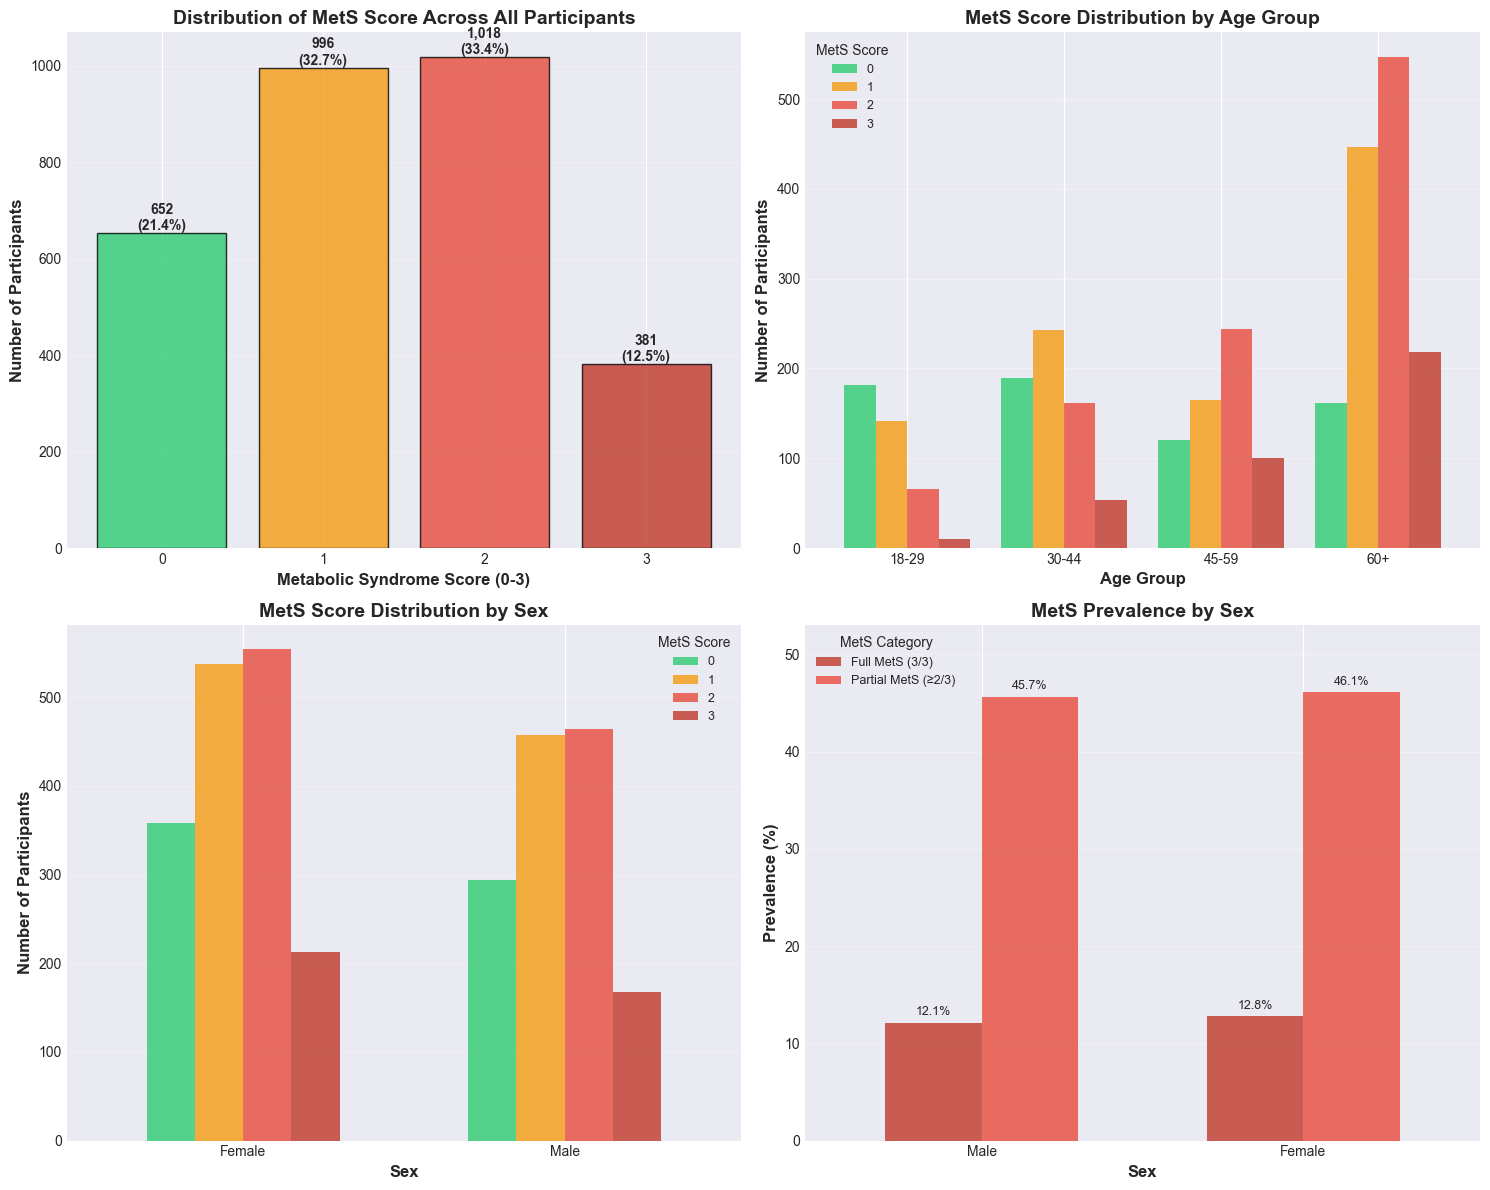

In [13]:
# Visualization - MetS Score Distribution

# Determine correct path based on current location
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/mets_score_distribution.png'
    else:
        save_path = '../results/figures/mets_score_distribution.png'
else:
    save_path = 'results/figures/mets_score_distribution.png'

print(f"Will save to: {save_path}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall score distribution
ax1 = axes[0, 0]
score_counts = df['mets_score'].value_counts().sort_index()
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b']
bars = ax1.bar(score_counts.index, score_counts.values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Metabolic Syndrome Score (0-3)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of MetS Score Across All Participants', fontsize=14, fontweight='bold')
ax1.set_xticks([0, 1, 2, 3])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/total_n*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Score distribution by age group
ax2 = axes[0, 1]
age_score_pivot = df.groupby(['age_group', 'mets_score']).size().unstack(fill_value=0)
age_score_pivot.plot(kind='bar', stacked=False, ax=ax2, color=colors, alpha=0.8, width=0.8)
ax2.set_xlabel('Age Group', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax2.set_title('MetS Score Distribution by Age Group', fontsize=14, fontweight='bold')
ax2.legend(title='MetS Score', title_fontsize=10, fontsize=9, loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(axis='y', alpha=0.3)

# 3. Score distribution by sex
ax3 = axes[1, 0]
sex_score_pivot = df.groupby(['sex_label', 'mets_score']).size().unstack(fill_value=0)
sex_score_pivot.plot(kind='bar', stacked=False, ax=ax3, color=colors, alpha=0.8, width=0.6)
ax3.set_xlabel('Sex', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax3.set_title('MetS Score Distribution by Sex', fontsize=14, fontweight='bold')
ax3.legend(title='MetS Score', title_fontsize=10, fontsize=9, loc='upper right')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.grid(axis='y', alpha=0.3)

# 4. Prevalence rates comparison
ax4 = axes[1, 1]
prevalence_data = pd.DataFrame({
    'Full MetS (3/3)': [
        df[df['sex_label']=='Male']['mets_full'].mean() * 100,
        df[df['sex_label']=='Female']['mets_full'].mean() * 100
    ],
    'Partial MetS (≥2/3)': [
        df[df['sex_label']=='Male']['mets_partial'].mean() * 100,
        df[df['sex_label']=='Female']['mets_partial'].mean() * 100
    ]
}, index=['Male', 'Female'])

prevalence_data.plot(kind='bar', ax=ax4, color=['#c0392b', '#e74c3c'], alpha=0.8, width=0.6)
ax4.set_xlabel('Sex', fontsize=12, fontweight='bold')
ax4.set_ylabel('Prevalence (%)', fontsize=12, fontweight='bold')
ax4.set_title('MetS Prevalence by Sex', fontsize=14, fontweight='bold')
ax4.legend(title='MetS Category', title_fontsize=10, fontsize=9)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax4.set_ylim(0, max(prevalence_data.max()) * 1.15)
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for container in ax4.containers:
    ax4.bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)

plt.tight_layout()
try:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {save_path}")
except Exception as e:
    print(f"\n✗ Could not save: {e}")
    print("Displaying plot only...")
plt.show()


✓ Saved: results/figures/mets_component_prevalence.png


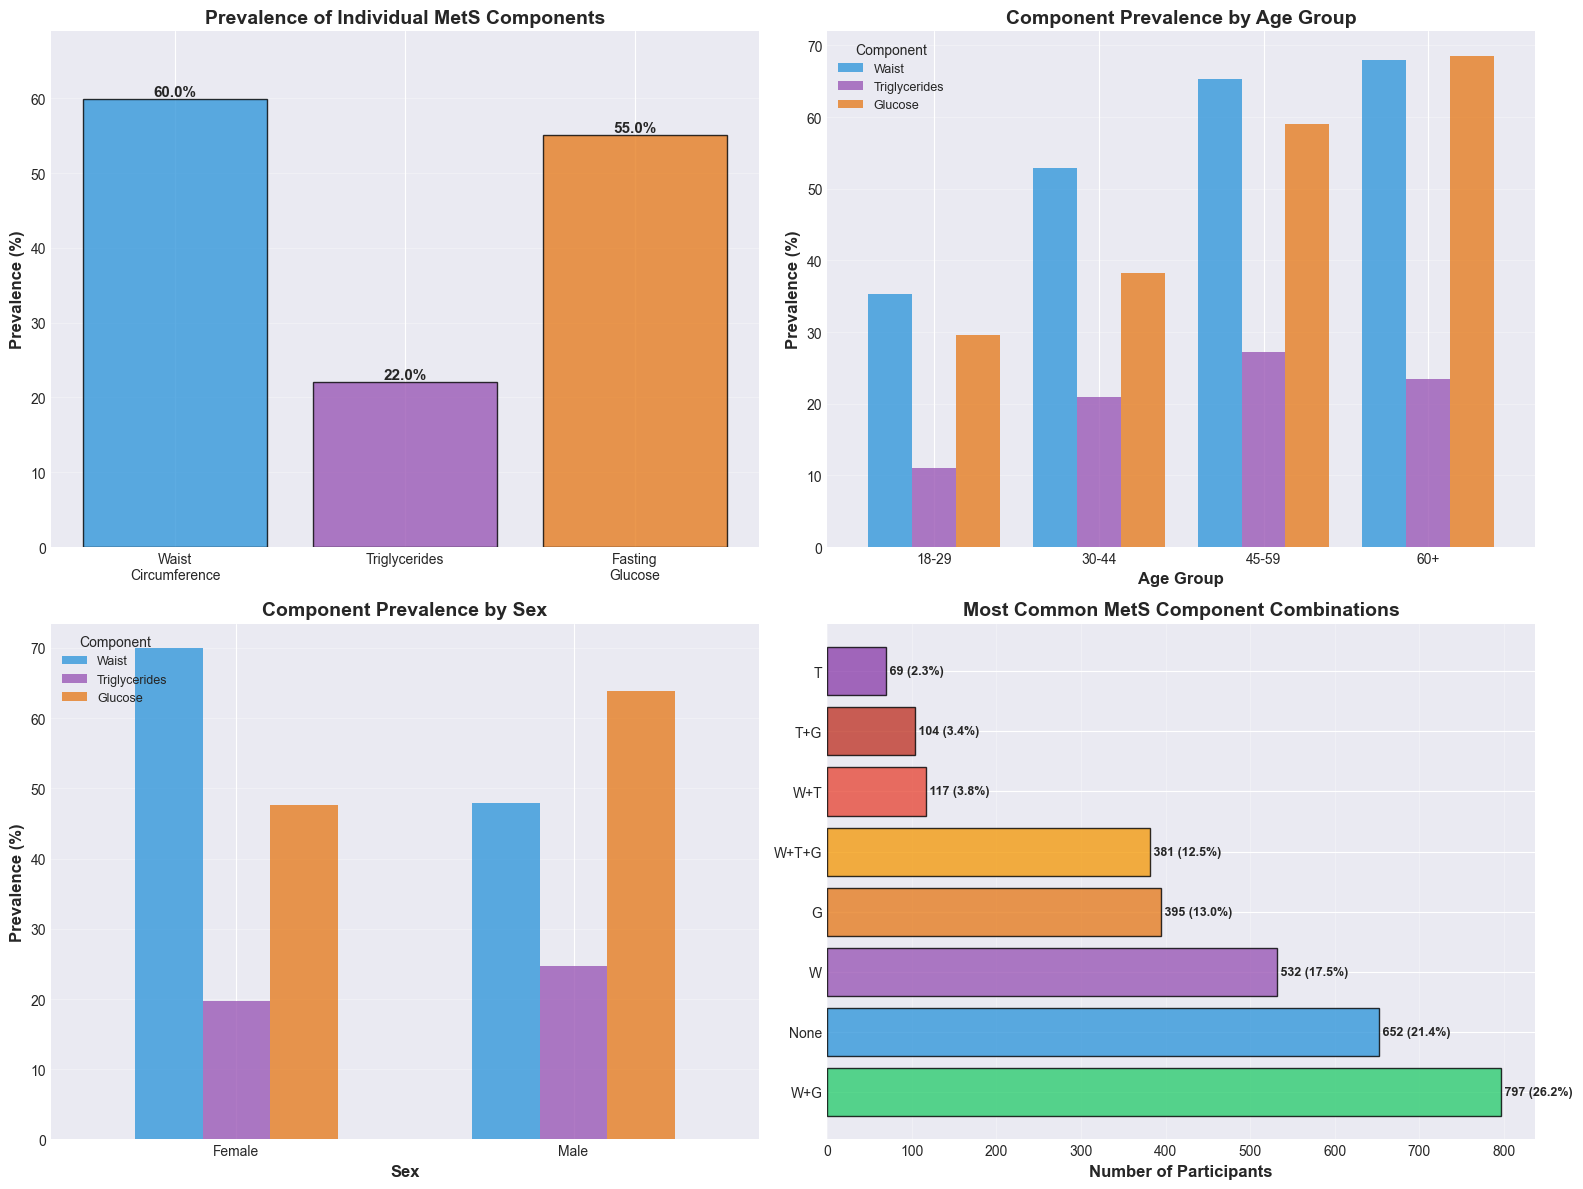

In [14]:
# Visualization - Component 
# Determine correct path
from pathlib import Path
current = Path.cwd()
if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/mets_component_prevalence.png'
    else:
        save_path = '../results/figures/mets_component_prevalence.png'
else:
    save_path = 'results/figures/mets_component_prevalence.png'

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall component prevalence
ax1 = axes[0, 0]
component_prev = pd.DataFrame({
    'Component': ['Waist\nCircumference', 'Triglycerides', 'Fasting\nGlucose'],
    'Prevalence': [
        df['mets_waist'].mean() * 100,
        df['mets_triglycerides'].mean() * 100,
        df['mets_glucose'].mean() * 100
    ]
})
bars = ax1.bar(component_prev['Component'], component_prev['Prevalence'], 
               color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black')
ax1.set_ylabel('Prevalence (%)', fontsize=12, fontweight='bold')
ax1.set_title('Prevalence of Individual MetS Components', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(component_prev['Prevalence']) * 1.15)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Component prevalence by age group
ax2 = axes[0, 1]
age_components = df.groupby('age_group')[['mets_waist', 'mets_triglycerides', 'mets_glucose']].mean() * 100
age_components.columns = ['Waist', 'Triglycerides', 'Glucose']
age_components.plot(kind='bar', ax=ax2, color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, width=0.8)
ax2.set_xlabel('Age Group', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prevalence (%)', fontsize=12, fontweight='bold')
ax2.set_title('Component Prevalence by Age Group', fontsize=14, fontweight='bold')
ax2.legend(title='Component', title_fontsize=10, fontsize=9)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(axis='y', alpha=0.3)

# 3. Component prevalence by sex
ax3 = axes[1, 0]
sex_components = df.groupby('sex_label')[['mets_waist', 'mets_triglycerides', 'mets_glucose']].mean() * 100
sex_components.columns = ['Waist', 'Triglycerides', 'Glucose']
sex_components.plot(kind='bar', ax=ax3, color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, width=0.6)
ax3.set_xlabel('Sex', fontsize=12, fontweight='bold')
ax3.set_ylabel('Prevalence (%)', fontsize=12, fontweight='bold')
ax3.set_title('Component Prevalence by Sex', fontsize=14, fontweight='bold')
ax3.legend(title='Component', title_fontsize=10, fontsize=9, loc='upper left')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.grid(axis='y', alpha=0.3)

# 4. Combination prevalence (top 8)
ax4 = axes[1, 1]
combo_top = combo_dist.head(8)
colors_combo = ['#2ecc71', '#3498db', '#9b59b6', '#e67e22', '#f39c12', '#e74c3c', '#c0392b', '#8e44ad']
bars = ax4.barh(range(len(combo_top)), combo_top.values, color=colors_combo[:len(combo_top)], 
                alpha=0.8, edgecolor='black')
ax4.set_yticks(range(len(combo_top)))
ax4.set_yticklabels(combo_top.index, fontsize=10)
ax4.set_xlabel('Number of Participants', fontsize=12, fontweight='bold')
ax4.set_title('Most Common MetS Component Combinations', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, combo_top.values)):
    width = bar.get_width()
    pct = val / total_n * 100
    ax4.text(width, bar.get_y() + bar.get_height()/2.,
            f' {int(val):,} ({pct:.1f}%)',
            ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
try:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {save_path}")
except Exception as e:
    print(f"\n✗ Could not save: {e}")
plt.show()


✓ Saved: results/figures/mets_demographic_heatmap.png


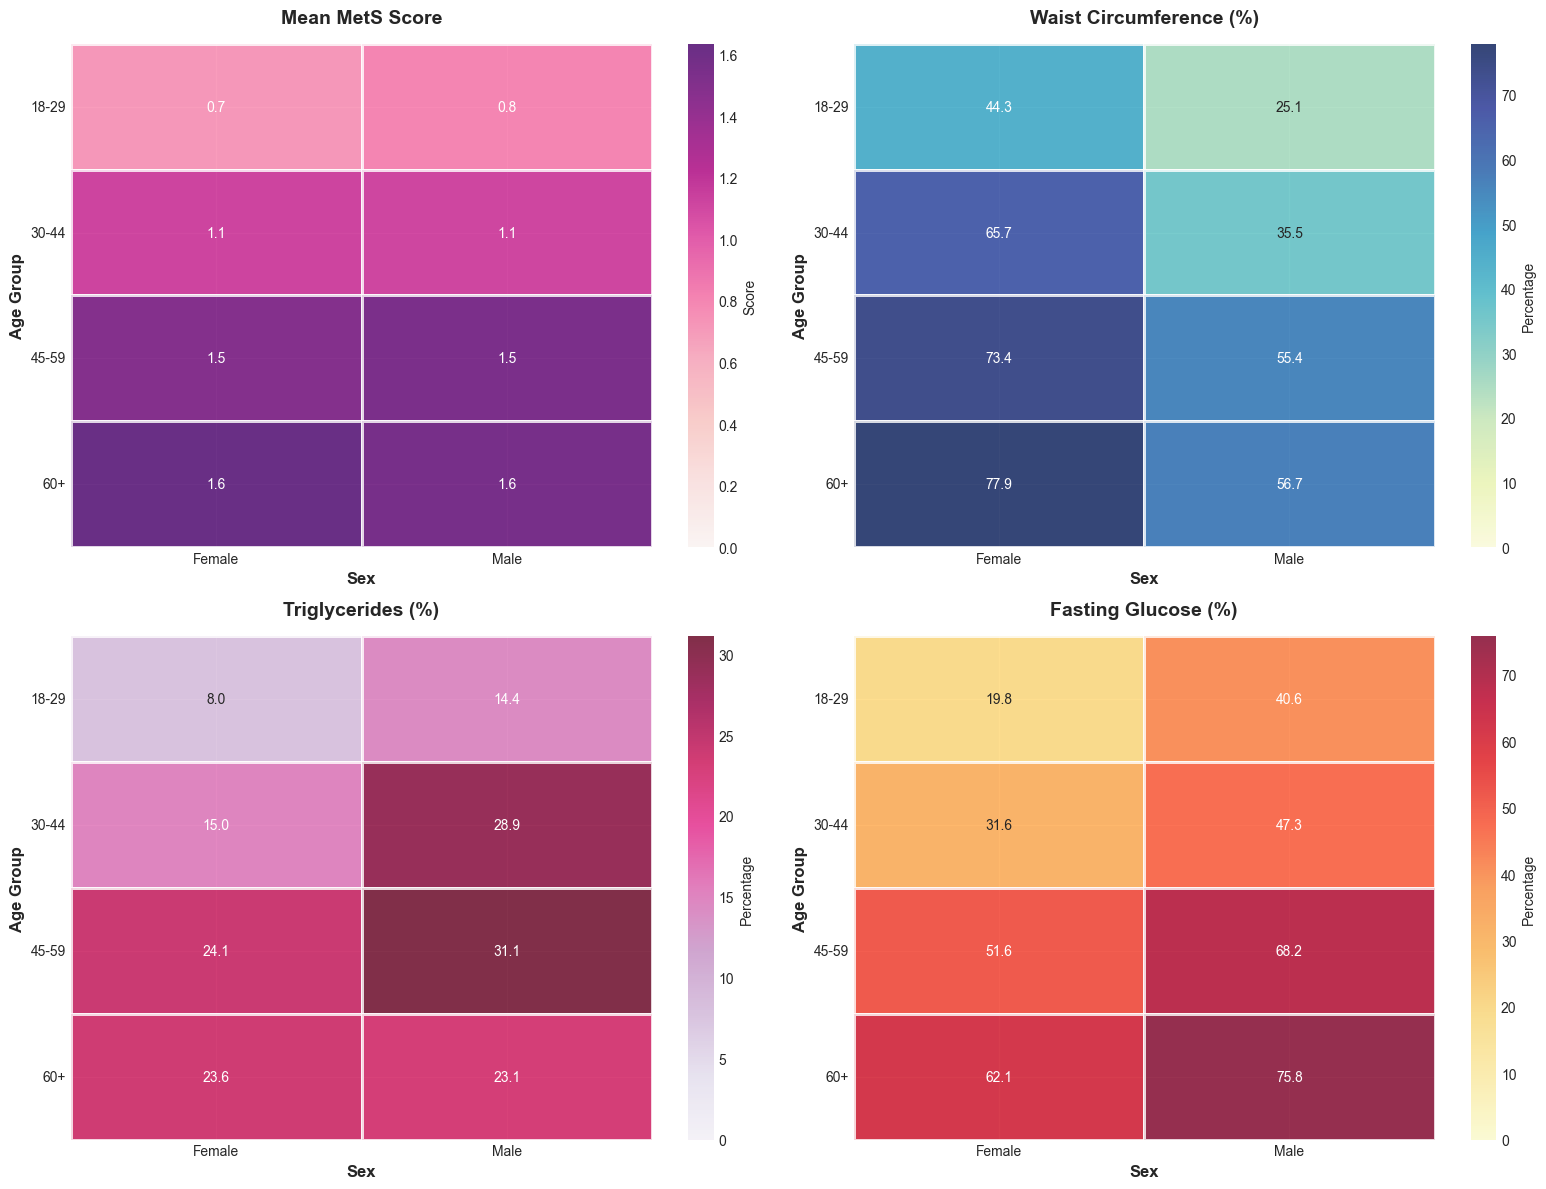

In [15]:
# Visualization - Demographic Heatmap
# Determine correct path
from pathlib import Path
current = Path.cwd()
if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/mets_demographic_heatmap.png'
    else:
        save_path = '../results/figures/mets_demographic_heatmap.png'
else:
    save_path = 'results/figures/mets_demographic_heatmap.png'

# Create comprehensive demographic breakdown
demographic_breakdown = df.groupby(['age_group', 'sex_label']).agg({
    'mets_score': 'mean',
    'mets_waist': 'mean',
    'mets_triglycerides': 'mean',
    'mets_glucose': 'mean',
    'SEQN': 'count'
}).round(3)

# Create heatmaps with pastel colors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define pastel color palettes for each heatmap
pastel_palettes = ['RdPu', 'YlGnBu', 'PuRd', 'YlOrRd']

components = [
    ('mets_score', 'Mean MetS Score', axes[0, 0], 'RdPu'),
    ('mets_waist', 'Waist Circumference (%)', axes[0, 1], 'YlGnBu'),
    ('mets_triglycerides', 'Triglycerides (%)', axes[1, 0], 'PuRd'),
    ('mets_glucose', 'Fasting Glucose (%)', axes[1, 1], 'YlOrRd')
]

for comp, title, ax, cmap in components:
    # Reshape for heatmap
    heatmap_data = demographic_breakdown[comp].unstack()
    
    # Convert to percentage if not score
    if comp != 'mets_score':
        heatmap_data = heatmap_data * 100
    
    # Create heatmap with pastel colors
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap=cmap, 
                cbar_kws={'label': 'Percentage' if comp != 'mets_score' else 'Score'},
                linewidths=2, linecolor='white', ax=ax, vmin=0, alpha=0.8)
    
    ax.set_xlabel('Sex', fontsize=12, fontweight='bold')
    ax.set_ylabel('Age Group', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
try:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {save_path}")
except Exception as e:
    print(f"\n✗ Could not save: {e}")
plt.show()

In [16]:
# Statistical Testing - Component Associations
from scipy.stats import chi2_contingency

# Chi-square test: Are component elevations independent?
contingency_table = pd.crosstab(
    [df['mets_waist'], df['mets_triglycerides']], 
    df['mets_glucose']
)

chi2, p_val, dof, expected = chi2_contingency(contingency_table)

print("\n🔬 Chi-Square Test: Independence of MetS Components")
print(f"   Null Hypothesis: Components are independent")
print(f"   Chi-square statistic: {chi2:.3f}")
print(f"   Degrees of freedom: {dof}")
print(f"   P-value: {p_val:.4e}")

if p_val < 0.001:
    print("   *** Components are NOT independent (p < 0.001)")
    print("   → Strong evidence of clustering/co-occurrence")
else:
    print("   Components appear independent")

# Pairwise component associations
print("\n Pairwise Component Associations:")

# Waist × Triglycerides
wt_both = ((df['mets_waist']==1) & (df['mets_triglycerides']==1)).sum()
wt_expected = (df['mets_waist'].sum() * df['mets_triglycerides'].sum()) / len(df)
wt_ratio = wt_both / wt_expected

print(f"\n   Waist × Triglycerides:")
print(f"   - Observed co-occurrence: {wt_both:,}")
print(f"   - Expected (if independent): {wt_expected:.0f}")
print(f"   - Ratio (Obs/Exp): {wt_ratio:.2f}")

# Waist × Glucose
wg_both = ((df['mets_waist']==1) & (df['mets_glucose']==1)).sum()
wg_expected = (df['mets_waist'].sum() * df['mets_glucose'].sum()) / len(df)
wg_ratio = wg_both / wg_expected

print(f"\n   Waist × Glucose:")
print(f"   - Observed co-occurrence: {wg_both:,}")
print(f"   - Expected (if independent): {wg_expected:.0f}")
print(f"   - Ratio (Obs/Exp): {wg_ratio:.2f}")

# Triglycerides × Glucose
tg_both = ((df['mets_triglycerides']==1) & (df['mets_glucose']==1)).sum()
tg_expected = (df['mets_triglycerides'].sum() * df['mets_glucose'].sum()) / len(df)
tg_ratio = tg_both / tg_expected

print(f"\n   Triglycerides × Glucose:")
print(f"   - Observed co-occurrence: {tg_both:,}")
print(f"   - Expected (if independent): {tg_expected:.0f}")
print(f"   - Ratio (Obs/Exp): {tg_ratio:.2f}")

# Interpretation
print("\n Interpretation:")
print("   Ratio > 1.0: Components occur together MORE than expected")
print("   Ratio = 1.0: Components occur together AS expected (independent)")
print("   Ratio < 1.0: Components occur together LESS than expected")


🔬 Chi-Square Test: Independence of MetS Components
   Null Hypothesis: Components are independent
   Chi-square statistic: 234.405
   Degrees of freedom: 3
   P-value: 1.5429e-50
   *** Components are NOT independent (p < 0.001)
   → Strong evidence of clustering/co-occurrence

 Pairwise Component Associations:

   Waist × Triglycerides:
   - Observed co-occurrence: 498
   - Expected (if independent): 402
   - Ratio (Obs/Exp): 1.24

   Waist × Glucose:
   - Observed co-occurrence: 1,178
   - Expected (if independent): 1006
   - Ratio (Obs/Exp): 1.17

   Triglycerides × Glucose:
   - Observed co-occurrence: 485
   - Expected (if independent): 369
   - Ratio (Obs/Exp): 1.31

 Interpretation:
   Ratio > 1.0: Components occur together MORE than expected
   Ratio = 1.0: Components occur together AS expected (independent)
   Ratio < 1.0: Components occur together LESS than expected


In [17]:
#  Create Summary Tables

# Determine correct path
from pathlib import Path
current = Path.cwd()
if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        table_path = '../../results/tables/'
    else:
        table_path = '../results/tables/'
else:
    table_path = 'results/tables/'

# 1. Overall MetS summary
overall_summary = pd.DataFrame({
    'Metric': [
        'Total Participants',
        'Elevated Waist (n)',
        'Elevated Waist (%)',
        'Elevated Triglycerides (n)',
        'Elevated Triglycerides (%)',
        'Impaired Fasting Glucose (n)',
        'Impaired Fasting Glucose (%)',
        'Partial MetS ≥2/3 (n)',
        'Partial MetS ≥2/3 (%)',
        'Full MetS 3/3 (n)',
        'Full MetS 3/3 (%)',
        'Mean MetS Score'
    ],
    'Value': [
        f"{total_n:,}",
        f"{waist_n:,}",
        f"{waist_n/total_n*100:.1f}",
        f"{trig_n:,}",
        f"{trig_n/total_n*100:.1f}",
        f"{gluc_n:,}",
        f"{gluc_n/total_n*100:.1f}",
        f"{partial_mets_n:,}",
        f"{partial_mets_n/total_n*100:.1f}",
        f"{full_mets_n:,}",
        f"{full_mets_n/total_n*100:.1f}",
        f"{df['mets_score'].mean():.2f}"
    ]
})

overall_summary.to_csv(table_path + 'mets_overall_summary.csv', index=False)
print(f"✓ Saved: {table_path}mets_overall_summary.csv")

# 2. Age stratified summary
age_mets.to_csv(table_path + 'mets_by_age_group.csv')
print(f"✓ Saved: {table_path}mets_by_age_group.csv")

# 3. Sex stratified summary
sex_mets.to_csv(table_path + 'mets_by_sex.csv')
print(f"✓ Saved: {table_path}mets_by_sex.csv")

# 4. Age × Sex interaction summary
age_sex_mets = df.groupby(['age_group', 'sex_label']).agg({
    'mets_score': ['mean', 'std'],
    'mets_full': 'mean',
    'mets_partial': 'mean',
    'SEQN': 'count'
}).round(3)

age_sex_mets.columns = ['_'.join(col).strip() for col in age_sex_mets.columns.values]
age_sex_mets = age_sex_mets.rename(columns={
    'mets_score_mean': 'Mean_Score',
    'mets_score_std': 'SD_Score',
    'mets_full_mean': 'Full_MetS_%',
    'mets_partial_mean': 'Partial_MetS_%',
    'SEQN_count': 'N'
})

# Convert to percentages
age_sex_mets['Full_MetS_%'] = (age_sex_mets['Full_MetS_%'] * 100).round(1)
age_sex_mets['Partial_MetS_%'] = (age_sex_mets['Partial_MetS_%'] * 100).round(1)

age_sex_mets.to_csv(table_path + 'mets_by_age_and_sex.csv')
print(f"✓ Saved: {table_path}mets_by_age_and_sex.csv")

# Display the age × sex table
print("\n" + "="*80)
print("AGE × SEX INTERACTION SUMMARY")
print("="*80)
print(age_sex_mets.to_string())

✓ Saved: results/tables/mets_overall_summary.csv
✓ Saved: results/tables/mets_by_age_group.csv
✓ Saved: results/tables/mets_by_sex.csv
✓ Saved: results/tables/mets_by_age_and_sex.csv

AGE × SEX INTERACTION SUMMARY
                     Mean_Score  SD_Score  Full_MetS_%  Partial_MetS_%    N
age_group sex_label                                                        
18-29     Female          0.722     0.787          1.9            17.0  212
          Male            0.802     0.848          3.2            21.4  187
30-44     Female          1.123     0.907          7.8            32.4  373
          Male            1.117     0.951          8.8            34.1  273
45-59     Female          1.490     0.993         15.8            54.2  349
          Male            1.546     0.953         16.1            55.4  280
60+       Female          1.636     0.895         17.1            57.8  729
          Male            1.556     0.884         14.4            53.4  644


In [18]:
# Clinical Insights and Key Findings

print("\n SUMMARY OF KEY FINDINGS:\n")

# Finding 1: Overall burden
print("1. METABOLIC BURDEN IN SAMPLE")
print(f"   • {partial_mets_n/total_n*100:.1f}% meet ≥2/3 MetS criteria (Partial MetS)")
print(f"   • {full_mets_n/total_n*100:.1f}% meet all 3/3 criteria (Full MetS)")
print(f"   • {waist_n/total_n*100:.1f}% have elevated waist circumference")
print(f"   → High-risk population warranting intervention")

# Finding 2: Most prevalent component
components_prev = {
    'Waist': waist_n/total_n*100,
    'Triglycerides': trig_n/total_n*100,
    'Glucose': gluc_n/total_n*100
}
most_prev = max(components_prev, key=components_prev.get)

print(f"\n2. MOST PREVALENT COMPONENT")
print(f"   • {most_prev} is the most common elevated component ({components_prev[most_prev]:.1f}%)")
print(f"   → Primary target for population-level intervention")

# Finding 3: Most common combination
most_common_combo = combo_dist.index[0]
most_common_count = combo_dist.values[0]

print(f"\n3. MOST COMMON COMBINATION")
print(f"   • '{most_common_combo}': {most_common_count:,} participants ({most_common_count/total_n*100:.1f}%)")
print(f"   • Description: {combo_descriptions.get(most_common_combo, 'N/A')}")

# Finding 4: Age trends
oldest_group = age_mets['Mean_Score'].idxmax()
youngest_group = age_mets['Mean_Score'].idxmin()

print(f"\n4. AGE TRENDS")
print(f"   • Highest MetS score: {oldest_group} (mean={age_mets.loc[oldest_group, 'Mean_Score']:.2f})")
print(f"   • Lowest MetS score: {youngest_group} (mean={age_mets.loc[youngest_group, 'Mean_Score']:.2f})")
print(f"   → Clear age-related gradient in metabolic risk")

# Finding 5: Sex differences
male_score = sex_mets.loc['Male', 'Mean_Score']
female_score = sex_mets.loc['Female', 'Mean_Score']

print(f"\n5. SEX DIFFERENCES")
print(f"   • Male mean score: {male_score:.2f}")
print(f"   • Female mean score: {female_score:.2f}")
if male_score > female_score:
    print(f"   → Males show higher metabolic risk (+{male_score-female_score:.2f} points)")
else:
    print(f"   → Females show higher metabolic risk (+{female_score-male_score:.2f} points)")

# Finding 6: Component clustering
print(f"\n6. COMPONENT CO-OCCURRENCE")
print(f"   • All three components elevated: {full_mets_n:,} participants")
print(f"   • Evidence of clustering: Obs/Exp ratios all > 1.0")
print(f"   → Components don't occur independently (shared pathophysiology)")

#  Save Enhanced Dataset with MetS Variables

# Determine correct path
from pathlib import Path
current = Path.cwd()
if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        output_path = "../../data/processed/nhanes_metabolic_with_mets.csv"
    else:
        output_path = "../data/processed/nhanes_metabolic_with_mets.csv"
else:
    output_path = "data/processed/nhanes_metabolic_with_mets.csv"

# Add MetS variables to dataset
mets_vars = [
    'mets_waist', 'mets_triglycerides', 'mets_glucose',
    'mets_score', 'mets_category', 'mets_full', 'mets_partial',
    'mets_combination'
]

print(f"\nAdding {len(mets_vars)} MetS-related variables to dataset:")
for var in mets_vars:
    print(f"  ✓ {var}")

# Save enhanced dataset
df.to_csv(output_path, index=False)
print(f"\n✓ Saved enhanced dataset: {output_path}")
print(f"  - Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  - Added {len(mets_vars)} MetS variables for clustering comparison")


 SUMMARY OF KEY FINDINGS:

1. METABOLIC BURDEN IN SAMPLE
   • 45.9% meet ≥2/3 MetS criteria (Partial MetS)
   • 12.5% meet all 3/3 criteria (Full MetS)
   • 60.0% have elevated waist circumference
   → High-risk population warranting intervention

2. MOST PREVALENT COMPONENT
   • Waist is the most common elevated component (60.0%)
   → Primary target for population-level intervention

3. MOST COMMON COMBINATION
   • 'W+G': 797 participants (26.2%)
   • Description: Waist + Glucose

4. AGE TRENDS
   • Highest MetS score: 60+ (mean=1.60)
   • Lowest MetS score: 18-29 (mean=0.76)
   → Clear age-related gradient in metabolic risk

5. SEX DIFFERENCES
   • Male mean score: 1.37
   • Female mean score: 1.37
   → Females show higher metabolic risk (+0.01 points)

6. COMPONENT CO-OCCURRENCE
   • All three components elevated: 381 participants
   • Evidence of clustering: Obs/Exp ratios all > 1.0
   → Components don't occur independently (shared pathophysiology)

Adding 8 MetS-related variables